<a href="https://colab.research.google.com/github/jeremysb1/forecasting/blob/main/fbprophet_parameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Data

In [1]:
# change directory
%cd /content/drive/MyDrive/Time Series Forecasting Product

/content/drive/MyDrive/Time Series Forecasting Product


In [2]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

In [3]:
# load the data
# YYYY-MM-DD
df = pd.read_csv('nyc_data.csv')
df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077


In [4]:
# rename variable
df = df.rename(columns = {'Demand': 'y',
                          'Date': 'ds'})
df.head(0)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing


In [5]:
# date variable
df.ds = pd.to_datetime(df.ds,
                       format = "%m/%d/%Y")
df.ds

0      2015-01-01
1      2015-01-02
2      2015-01-03
3      2015-01-04
4      2015-01-05
          ...    
2187   2020-12-27
2188   2020-12-28
2189   2020-12-29
2190   2020-12-30
2191   2020-12-31
Name: ds, Length: 2192, dtype: datetime64[ns]

# Holidays

In [6]:
# Easter
dates = pd.to_datetime(df[df.Easter == 1].ds)
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': dates,
                       'lower_window': -5,
                       'upper_window': 2})

In [7]:
# Thankgiving
dates = pd.to_datetime(df[df.Thanksgiving == 1].ds)
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
                             'ds': dates,
                             'lower_window': -3,
                             'upper_window': 6})
thanksgiving

,holiday,ds,lower_window,upper_window
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6
1792,thanksgiving,2019-11-28,-3,6
2156,thanksgiving,2020-11-26,-3,6


In [8]:
# combining holidays
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6


In [9]:
df = df.drop(columns = ["Easter", "Thanksgiving"])
df.head(0)

,ds,y,Christmas,Temperature,Marketing


# Facebook Prophet Model

In [ ]:
# FB model
m = Prophet(holidays = holidays,
            seasonality_mode='multiplicative',
            seasonality_prior_scale=10,
            holidays_prior_scale=10,
            changepoint_prior_scale=0.05)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.add_regressor('Marketing')
m.fit(df)

In [11]:
# check how many observations
df.shape[0] - 180

2012

In [ ]:
# cross-validation
df_cv = cross_validation(m,
                         horizon = '31 days',
                         period = '16 days',
                         initial = '2012 days',
                         parallel = 'processes')
df_cv.head()

In [13]:
# performance
performance_metrics(df_cv).head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,2851.098789,53.395681,43.470653,0.059104,0.060362,0.060251,0.767742
1,5 days,2836.677028,53.260464,44.567996,0.062290,0.064404,0.063157,0.767742
2,6 days,3557.733802,59.646742,50.666561,0.070010,0.064404,0.071500,0.732258
3,7 days,2851.628458,53.400641,43.245387,0.060954,0.059650,0.062075,0.735484
4,8 days,2799.686506,52.912064,40.808150,0.056397,0.057064,0.057947,0.735484


In [16]:
# RMSE and MAPE
print("RMSE: ", round(performance_metrics(df_cv)["rmse"].mean(),1))
print("MAPE: ", 100 * round(performance_metrics(df_cv)["mape"].mean(),3), "%")

RMSE:  53.9
MAPE:  5.800000000000001 %


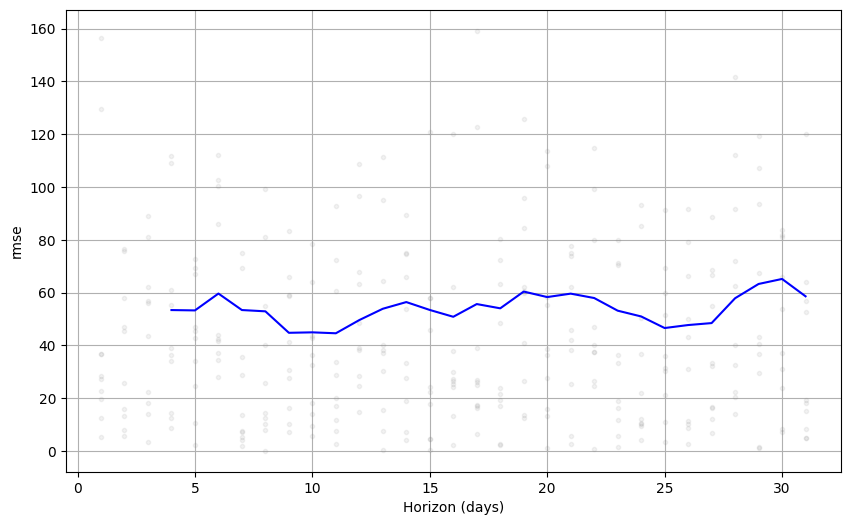

In [17]:
# plotting
plot_cross_validation_metric(df_cv, metric = 'rmse');